# Assignment 04: Convolutional Neural Networks

In [15]:
"""
Lam Nguyen
NID: la815794
Due Date: 05Apr2024

- Basic operations for Digital Image Processing (DIP)
- LeNet-5 (Google Colab is recommended for implementation)

Tasks:

    1. Create an example of a convolutional filter. Apply a kernel to an image and display the output
        a. Prepare a 3x3 Laplacian kernel
        b. Convolve the image use a stride of 2
        c. Display convolved image

    2. Create an example of max pooling.
        a. Prepare a 2x2 pooling mask
        b. Use Max Pooling
        c. Apply the pooling mask to an image. Use a stride of 2

    3. Create and apply LeNet-5
        a. Use the Fashion MNIST Dataset
        b. Create the model
        c. Train the model
            i. Batch size = 64
            ii. SGD Optimizer
            iii. Learning Rate = 0.1
            iv. Momentum =0.9
            v. Nesterov = True
            vi. Num of Epoch = 10 
            

"""

'\nLam Nguyen\nNID: la815794\nDue Date: 05Apr2024\n\n- Basic operations for Digital Image Processing (DIP)\n- LeNet-5 (Google Colab is recommended for implementation)\n\nTasks:\n\n    1. Create an example of a convolutional filter. Apply a kernel to an image and display the output\n        a. Prepare a 3x3 Laplacian kernel\n        b. Convolve the image use a stride of 2\n        c. Display convolved image\n\n    2. Create an example of max pooling.\n        a. Prepare a 2x2 pooling mask\n        b. Use Max Pooling\n        c. Apply the pooling mask to an image. Use a stride of 2\n\n    3. Create and apply LeNet-5\n        a. Use the Fashion MNIST Dataset\n        b. Create the model\n        c. Train the model\n            i. Batch size = 64\n            ii. SGD Optimizer\n            iii. Learning Rate = 0.1\n            iv. Momentum =0.9\n            v. Nesterov = True\n            vi. Num of Epoch = 10 \n            \n\n'

## Implement Convolutional Filter

#### Source : https://github.com/detkov/Convolution-From-Scratch

In [16]:
# Create Code For Convolution: 

import numpy as np
from typing import List, Tuple, Union

def add_padding(matrix: np.ndarray, 
                padding: Tuple[int, int]) -> np.ndarray:
    """Adds padding to the matrix. 

    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix

    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
    """
    n, m = matrix.shape
    r, c = padding
    
    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix
    
    return padded_matrix


def _check_params(matrix, kernel, stride, dilation, padding):
    params_are_correct = (isinstance(stride[0], int)   and isinstance(stride[1], int)   and
                          isinstance(dilation[0], int) and isinstance(dilation[1], int) and
                          isinstance(padding[0], int)  and isinstance(padding[1], int)  and
                          stride[0]   >= 1 and stride[1]   >= 1 and 
                          dilation[0] >= 1 and dilation[1] >= 1 and
                          padding[0]  >= 0 and padding[1]  >= 0)
    assert params_are_correct, 'Parameters should be integers equal or greater than default values.'
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    n, m = matrix.shape
    matrix = matrix if list(padding) == [0, 0] else add_padding(matrix, padding)
    n_p, m_p = matrix.shape

    if not isinstance(kernel, np.ndarray):
        kernel = np.array(kernel)
    k = kernel.shape
    
    kernel_is_correct = k[0] % 2 == 1 and k[1] % 2 == 1
    assert kernel_is_correct, 'Kernel shape should be odd.'
    matrix_to_kernel_is_correct = n_p >= k[0] and m_p >= k[1]
    assert matrix_to_kernel_is_correct, 'Kernel can\'t be bigger than matrix in terms of shape.'
    
    h_out = np.floor((n + 2 * padding[0] - k[0] - (k[0] - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - k[1] - (k[1] - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    out_dimensions_are_correct = h_out > 0 and w_out > 0
    assert out_dimensions_are_correct, 'Can\'t apply input parameters, one of resulting output dimension is non-positive.'

    return matrix, kernel, k, h_out, w_out


def conv2d(matrix: Union[List[List[float]], np.ndarray], 
             kernel: Union[List[List[float]], np.ndarray], 
             stride: Tuple[int, int] = (1, 1), 
             dilation: Tuple[int, int] = (1, 1), 
             padding: Tuple[int, int] = (0, 0)) -> np.ndarray:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.

    Args:
        matrix (Union[List[List[float]], np.ndarray]): 2D matrix to be convolved.
        kernel (Union[List[List[float]], np.ndarray]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).

    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    matrix, kernel, k, h_out, w_out = _check_params(matrix, kernel, stride, dilation, padding)
    matrix_out = np.zeros((h_out, w_out))
    
    b = k[0] // 2, k[1] // 2
    center_x_0 = b[0] * dilation[0]
    center_y_0 = b[1] * dilation[1]
    for i in range(h_out):
        center_x = center_x_0 + i * stride[0]
        indices_x = [center_x + l * dilation[0] for l in range(-b[0], b[0] + 1)]
        for j in range(w_out):
            center_y = center_y_0 + j * stride[1]
            indices_y = [center_y + l * dilation[1] for l in range(-b[1], b[1] + 1)]

            submatrix = matrix[indices_x, :][:, indices_y]

            matrix_out[i][j] = np.sum(np.multiply(submatrix, kernel))
    return matrix_out





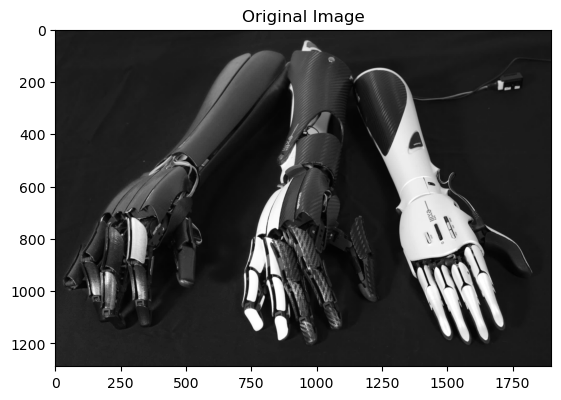

In [17]:
# 

import matplotlib.pyplot as plt
from PIL import Image

# Import Image and Display
input_img_path = 'data/Conv_input.png'
im = Image.open(input_img_path).convert("L") # Convert to Greyscale single channel image
plt.imshow(im,cmap='gray')
plt.title("Original Image")
plt.show()





Laplacian Output:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  1.]
 [ 0.  0.  0. ...  0.  0.  1.]
 [-1. -1. -1. ...  0.  0.  1.]]
Input Shape:  (1288, 1898)
Output Shape:  (643, 948)


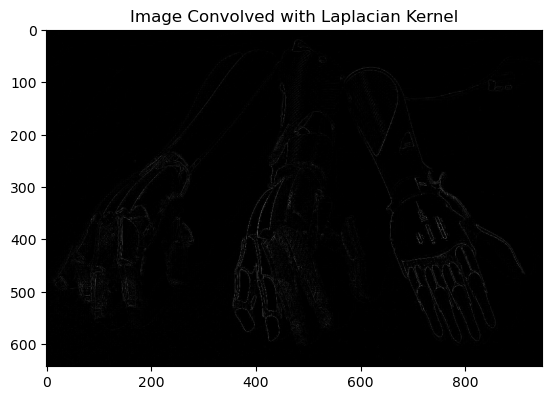

In [18]:
# Create Filter and Apply

# Create 3x3 Laplacian Kernel
kernel = np.array([
    [0,1,0],
    [1,-4,1],
    [0,1,0]
    ])

# Convert Image to Array
im = np.array(im)

# Apply Convolution
image_array = conv2d(im,kernel,stride=(2,2))
image_convolved = Image.fromarray(image_array)

print("Laplacian Output: ", image_array)
print("Input Shape: ", im.shape)
print("Output Shape: ", image_array.shape)

plt.imshow(image_convolved)
plt.title('Image Convolved with Laplacian Kernel')
plt.show()



## Implement Max Pooling

#### Source: https://www.geeksforgeeks.org/apply-a-2d-max-pooling-in-pytorch/

In [19]:
# Create Max Pooling

from PIL import Image
import numpy as np

class MaxPool2D():
    """
    Applies 2D max pooling to the input tensor.
    
    Args:
        inputs: a 3D NumPy array with dimensions (height, width, channels).
        pool_size: a tuple (pH, pW) or integer specifying the size of the pooling window.
        strides: a tuple (sH, sW) or integer specifying the strides of the pooling operation.
                 If None strides will be equivalent to the pool size.
    """

    def __init__(self, pool_size=(2,2), strides=None, padding='valid') -> None:
        self.pool_size = tuple(pool_size) if isinstance(pool_size, tuple) else (pool_size,) * 2
        if not isinstance(strides, tuple) and strides is not None:
            strides = (strides,strides) if isinstance(strides, int) else tuple(strides)
        self.strides = strides or self.pool_size
        if padding.lower() not in {'valid','same'}:
            raise ValueError(
                'Padding must be valid or same but received: {padding}'
            )
        self.padding = padding

    def __call__(self,inputs):
        pool_height, pool_width = self.pool_size
        strides, _ = self.strides
        height, width, channels = inputs.shape
        m_height = (height - pool_height) // strides + 1
        m_width = (width - pool_width) // strides + 1
        outputs = np.empty((m_height, m_width, channels))
        
        for h in range(m_height):
            for w in range(m_width):
                window = inputs[h*strides:h*strides+pool_height, w*strides:w*strides+pool_width, :]
                outputs[h, w, :] = np.amax(window, axis=(0, 1))
        
        return outputs.astype(np.uint8)

Max Pool Output:  [[[33 34 29]
  [33 34 29]
  [33 34 29]
  ...
  [29 25 22]
  [29 25 22]
  [29 25 22]]

 [[33 34 29]
  [33 34 29]
  [33 34 29]
  ...
  [29 25 22]
  [29 25 22]
  [29 25 22]]

 [[33 34 29]
  [33 34 29]
  [33 34 29]
  ...
  [29 25 22]
  [29 25 22]
  [29 25 22]]

 ...

 [[41 39 40]
  [41 39 40]
  [41 39 40]
  ...
  [25 24 22]
  [25 24 22]
  [26 25 23]]

 [[39 37 38]
  [39 37 38]
  [39 37 38]
  ...
  [25 24 22]
  [25 24 22]
  [26 25 23]]

 [[38 36 37]
  [38 36 37]
  [38 36 37]
  ...
  [25 24 22]
  [25 24 22]
  [26 25 23]]]
Input Shape:  (1288, 1898, 3)
Output Shape:  (644, 949, 3)


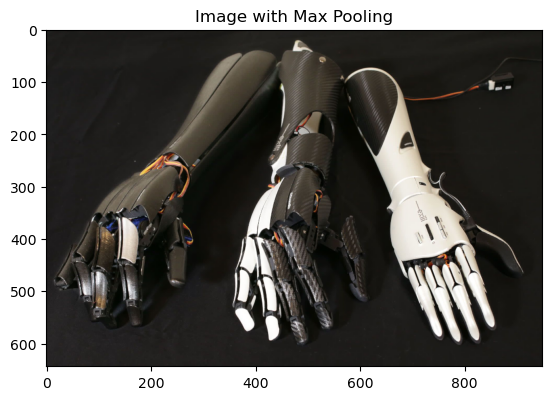

In [20]:
# Apply Max Pooling
input_img_path = 'data/Conv_input.png'
im = Image.open(input_img_path)
im = np.asarray(im)

pool_img_array = MaxPool2D(pool_size=2,strides=2)(im)

pool_img=Image.fromarray(pool_img_array)

print("Max Pool Output: ", pool_img_array)
print("Input Shape: ", im.shape)
print("Output Shape: ", pool_img_array.shape)


plt.imshow(pool_img)
plt.title("Image with Max Pooling")
plt.show()

## Implement LeNet-5

#### Source: https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4
#### Source: https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37


In [21]:
# Create LeNet-5 
import torch
from torch import nn
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()# The Super keyword calls the initialization of the parent class
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

#Initialize Model
model = LeNet5().to(device) 
summary(model, (1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 5, 5]            --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
|    └─Tanh: 2-2                         [-1, 6, 28, 28]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 14, 14]           --
|    └─Conv2d: 2-4                       [-1, 16, 10, 10]          2,416
|    └─Tanh: 2-5                         [-1, 16, 10, 10]          --
|    └─AvgPool2d: 2-6                    [-1, 16, 5, 5]            --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Flatten: 2-7                      [-1, 400]                 --
|    └─Linear: 2-8                       [-1, 120]                 48,120
|    └─Tanh: 2-9                         [-1, 120]                 --
|    └─Linear: 2-10                      [-1, 84]                  10,164
|    └─Tanh: 2-11                        [-1, 84]                  --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 5, 5]            --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
|    └─Tanh: 2-2                         [-1, 6, 28, 28]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 14, 14]           --
|    └─Conv2d: 2-4                       [-1, 16, 10, 10]          2,416
|    └─Tanh: 2-5                         [-1, 16, 10, 10]          --
|    └─AvgPool2d: 2-6                    [-1, 16, 5, 5]            --
├─Sequential: 1-2                        [-1, 10]                  --
|    └─Flatten: 2-7                      [-1, 400]                 --
|    └─Linear: 2-8                       [-1, 120]                 48,120
|    └─Tanh: 2-9                         [-1, 120]                 --
|    └─Linear: 2-10                      [-1, 84]                  10,164
|    └─Tanh: 2-11                        [-1, 84]                  --
|  

100%|██████████| 26421880/26421880 [00:03<00:00, 8216076.45it/s] 


Extracting data/FashionDataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionDataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 145389.43it/s]


Extracting data/FashionDataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionDataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2674029.39it/s]


Extracting data/FashionDataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionDataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8123505.26it/s]


Extracting data/FashionDataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionDataset/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:03<00:00, 8629990.14it/s] 


Extracting data/FasionDataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FasionDataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 224269.75it/s]


Extracting data/FasionDataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FasionDataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2693154.63it/s]


Extracting data/FasionDataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FasionDataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9327117.49it/s]

Extracting data/FasionDataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FasionDataset/FashionMNIST/raw



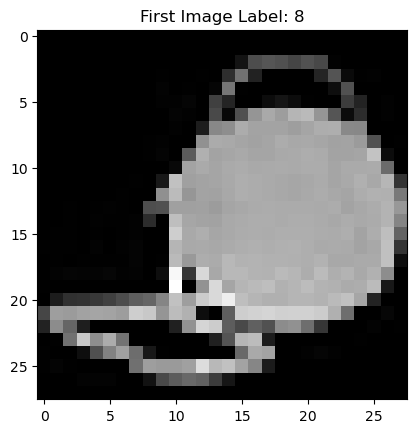

Shape of the Training batch for FashionMNIST torch.Size([64, 1, 28, 28])
Size of the Training Set for FashionMNIST:  60000
Size of Test Set for FashionMNIST:  10000


In [22]:
# Import Datasets, Process and set hyperparameters
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler # for validation test

input_size = 28*28
hidden_size = 100
num_classes= 10
learning_rate = 0.1
batch_size = 64
num_epochs = 11
momentum = 0.9
Nesterov = True
regularizer=4e-5


# Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,),)])
# mean and std have to be sequences (e.g, tuples),
# Therefore we should add a comma after the values


# Load the data: train and test sets
trainset = datasets.FashionMNIST('data/FashionDataset',download=True,train=True,transform=transform)
testset = datasets.FashionMNIST('data/FasionDataset',download=True,train=False,transform=transform)

# Preparing for validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)

# To get 20% of the training set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset,sampler=train_sample,batch_size=batch_size)
validloader = torch.utils.data.DataLoader(trainset,sampler=valid_sample, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True)


# Iterate through Training Dataset and print first image
example = iter(trainloader)

images,labels = example.__next__()

plt.imshow(np.squeeze(images[0]),cmap='gray')
plt.title(f"First Image Label: {labels[0]}")

plt.show()

# Display shape of total training Data, the number  of training samples and the number of test samples
print("Shape of the Training batch for FashionMNIST", images.shape )
print("Size of the Training Set for FashionMNIST: ",len(torch.utils.data.DataLoader(trainset)))
print("Size of Test Set for FashionMNIST: ", len(torch.utils.data.DataLoader(testset)))

In [26]:
# Train Model


# Import some packages for logging training and showing progress
from tqdm_loggable.auto import tqdm
from tqdm_loggable.tqdm_logging import tqdm_logging
import torch.optim as optim # Optimization algorithms
from torchmetrics import Accuracy

# Check Accuracy

def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad(): # No gradients have to be calculated
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            #x = x.reshape(x.shape[0], -1) # Have to reshape data. Why? Let me figure it out.

            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples) * 100:.2f}')


    model.train()
    acc = num_correct/num_samples
    return acc


# Define the loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate,
                      momentum=momentum,
                      nesterov=Nesterov,
                      weight_decay=regularizer
                      )

epoch_counter= 0
# Train Network
train_loss = 0.0

for epoch in range(num_epochs):
    check_accuracy(testloader,model)
    print("Training Loss:", train_loss)
    train_loss = 0.0
    tqdm.write(f"Training Epoch {epoch+1}/{num_epochs}")
    
   #  print("Training Loss: ", train_loss)
    for batch_idx, (images, labels) in enumerate(tqdm(trainloader)):
        

        images = images.to(device=device) # Images
        labels = labels.to(device=device) # label that classifies image


        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels) # Predicted outputs vs actual labels

        # Go Backward in the network:
        optimizer.zero_grad() # Empty the values in the gradient attribute
        loss.backward() # Backpropagation

        # gradient descent or adam step
        optimizer.step() # Update parameters

        train_loss += loss.item()*images.size(0)



epoch_counter = 0

accuracy = Accuracy(task='multiclass', num_classes=10).to(device=device)

 # Validation loop
val_loss, val_acc = 0.0, 0.0
model.eval() 
with torch.inference_mode():
        for X, y in validloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc
            
        val_loss /= len(validloader)
        val_acc /= len(validloader)
        

    
print(f"Epoch: {epoch}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")
        
        
 

Checking accuracy on test data
Got 1408 / 10000 with accuracy 14.08
Training Loss: 0.0
Training Epoch 1/11


100%|██████████| 188/188 [00:00<00:00, 214.91it/s]


Checking accuracy on test data
Got 7926 / 10000 with accuracy 79.26
Training Loss: 9074.360712051392
Training Epoch 2/11


100%|██████████| 188/188 [00:00<00:00, 263.81it/s]


Checking accuracy on test data
Got 8203 / 10000 with accuracy 82.03
Training Loss: 5834.555672645569
Training Epoch 3/11


100%|██████████| 188/188 [00:00<00:00, 275.80it/s]


Checking accuracy on test data
Got 8268 / 10000 with accuracy 82.68
Training Loss: 5109.238295555115
Training Epoch 4/11


100%|██████████| 188/188 [00:00<00:00, 273.10it/s]


Checking accuracy on test data
Got 8371 / 10000 with accuracy 83.71
Training Loss: 4746.061372756958
Training Epoch 5/11


100%|██████████| 188/188 [00:00<00:00, 248.43it/s]


Checking accuracy on test data
Got 8433 / 10000 with accuracy 84.33
Training Loss: 4410.017666339874
Training Epoch 6/11


100%|██████████| 188/188 [00:00<00:00, 278.74it/s]


Checking accuracy on test data
Got 8496 / 10000 with accuracy 84.96
Training Loss: 4102.278937339783
Training Epoch 7/11


100%|██████████| 188/188 [00:00<00:00, 273.40it/s]


Checking accuracy on test data
Got 8210 / 10000 with accuracy 82.10
Training Loss: 3854.315260887146
Training Epoch 8/11


100%|██████████| 188/188 [00:00<00:00, 267.39it/s]


Checking accuracy on test data
Got 8565 / 10000 with accuracy 85.65
Training Loss: 3650.9907360076904
Training Epoch 9/11


100%|██████████| 188/188 [00:00<00:00, 271.26it/s]


Checking accuracy on test data
Got 8376 / 10000 with accuracy 83.76
Training Loss: 3417.1345982551575
Training Epoch 10/11


100%|██████████| 188/188 [00:00<00:00, 261.38it/s]


Checking accuracy on test data
Got 8552 / 10000 with accuracy 85.52
Training Loss: 3195.3533577919006
Training Epoch 11/11


100%|██████████| 188/188 [00:00<00:00, 272.36it/s]


Epoch: 10| Val loss:  0.42421| Val acc:  0.85771
